# MNIST Digit Addition (Single Digit)
The digit addition problem is a simple but illustrative example used in (Manhaeve et al. 2018) to illustrate DeepProbLog’s ability to do both logical reasoning and deep learning. We will also use this simple example to show how to use NeurASP.

The task is, given a pair of digit images (MNIST) and their sum as the label, let a neural network learn the digit classification of the input images.
## Data Format
### dataList
A list of Python dictionaries as shown below, each dictionary maps logic symbols (in the form of strings) to tensors. In this problem, each dictionary in dataList denotes one single training instance and maps i1 and i2 in the NeurASP program to 2 tensors. Each dataTensor is an image of size (1,28,28) in MNIST dataset. 

    [
        {'i1' : dataTensor1, 'i2' : dataTensor2} ,
        ... ,
        {'i1' : dataTensor1', 'i2' : dataTensor2'}
    ]

### obsList
A list of constraints (in the form of strings), whose probabilities are to be maximized during training. The length of obsList is the same as the length of dataList, which is also the number of training instances. An example element of obsList is shown below. 

    ':- not addition(i1, i2, 12).'

### test_loader
Pytorch DataLoader object consisting of 10 batches in the following format

    [  
        [dataTensors, labelTensors]  
        ...  
        [dataTensors, labelTensors]  
    ]

Here dataTensors is a list of 1000 tensor of size (1,28,28) for a digit image, and labelTensors is a list of 1000 corresponding labels in the form of integer tensors. 
## Imports

In [1]:
import sys
sys.path.append('../../')
import time

import torch

from dataGen import dataList, obsList, test_loader
from network import Net
from neurasp import NeurASP

## NeurASP Program
The NeurASP program can be written in the form of ''' Rules '''

In [2]:
dprogram = '''
img(i1). img(i2).
addition(A,B,N) :- digit(0,A,N1), digit(0,B,N2), N=N1+N2.
nn(digit(1,X), [0,1,2,3,4,5,6,7,8,9]) :- img(X).
'''

## Neural Network Instantiation
- Instantiate neural networks.
- Define nnMapping: a dictionary that maps neural network names (i.e., strings) to the neural network objects (i.e., torch.nn.Module object)
- Define optimizers: a dictionary that maps neural network names (i.e., strings) to optimizer (we use the Adam optimizer here).

In [3]:
m = Net()
nnMapping = {'digit': m}
optimizers = {'digit': torch.optim.Adam(m.parameters(), lr=0.001)}

## Create NeurASP Object

In [4]:
NeurASPobj = NeurASP(dprogram, nnMapping, optimizers)

## Training and Testing

In [6]:
saveModelPath = 'data/model.pt'
startTime = time.time()

for i in range(1):
    print('Epoch {}...'.format(i+1))
    time1 = time.time()
    NeurASPobj.learn(dataList=dataList, obsList=obsList, epoch=1, smPickle='data/stableModels.pickle')
    time2 = time.time()
    acc, _ = NeurASPobj.testNN('digit', test_loader)
    print('Test Acc: {:0.2f}%'.format(acc))
    print('Storing the trained model into {}'.format(saveModelPath))
    torch.save(m.state_dict(), saveModelPath)
    print('--- train time: %s seconds ---' % (time2 - time1))
    print('--- test time: %s seconds ---' % (time.time() - time2))
    print('--- total time from beginning: %s minutes ---' % int((time.time() - startTime)/60) )

Epoch 1...
Test Acc: 7.73%
Storing the trained model into data/model.pt
--- train time: 347.13347601890564 seconds ---
--- test time: 1.168109655380249 seconds ---
--- total time from beginning: 5 minutes ---


## NeurASP vs DeepProbLog vs CNN
The following image shows the accuracy on the test data after each iteration of training.
The method CNN denotes the baseline introduced in (Manhaeve et al. 2018) where a convolutional neural network (with more parameters) is trained to classify the concatenation of the two images into the 19 possible sums. 

As we can see, the neural networks trained by NeurASP and DeepProbLog converge much
faster than CNN and have almost the same accuracy at each iteration. However, NeurASP
spends much less time for training compared to DeepProbLog. The time reported is for one
epoch (30,000 iterations in gradient descent). This is because DeepProbLog constructs an
SDD (Sequential Decision Diagram) at each iteration for each training instance (i.e., each pair of images) while SDD construction is time consuming.

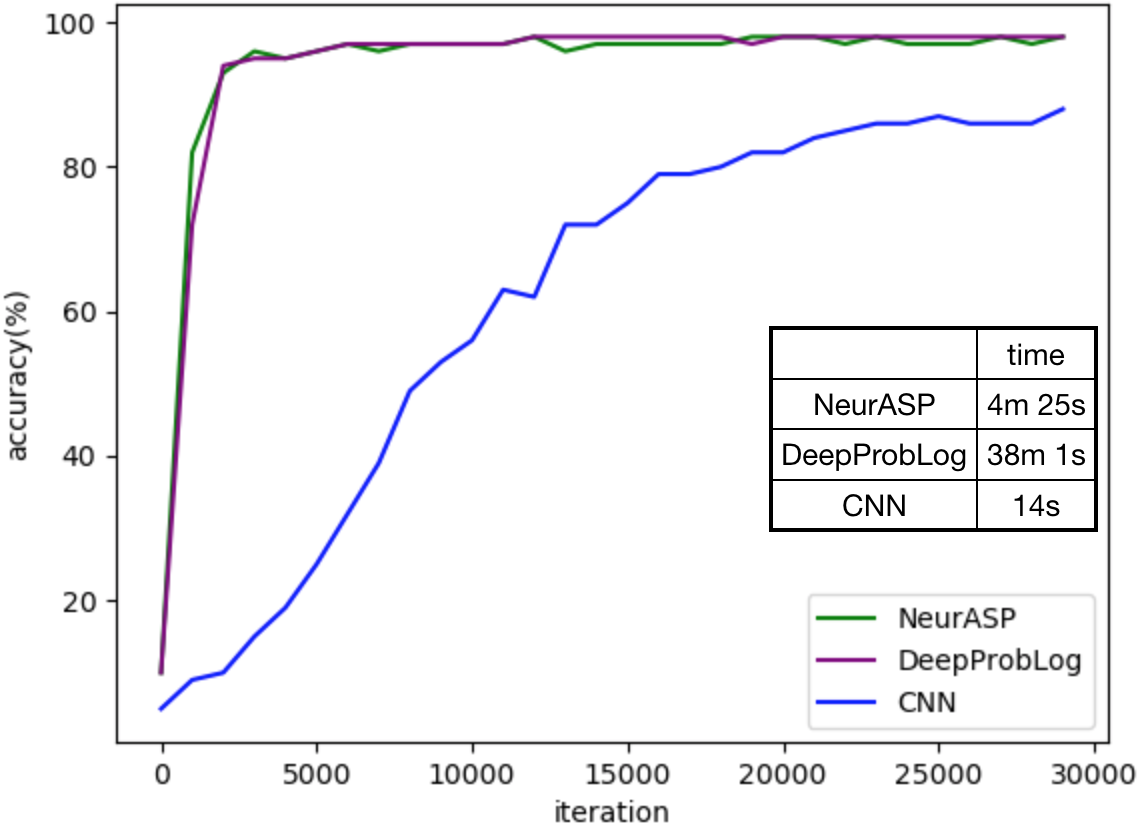

In [6]:
from IPython.display import display
from PIL import Image
path = 'data/NeurASPvsDeepProbLog.png'
display(Image.open(path))